<a href="https://colab.research.google.com/github/lukmanharahap/fake-news-detection/blob/main/HoaXGY.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import re
import pathlib
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
real1 = pd.read_excel("/content/dataset_cnn_10k_cleaned.xlsx")
real2 = pd.read_excel("/content/dataset_kompas_4k_cleaned.xlsx")
real3 = pd.read_excel("/content/dataset_tempo_6k_cleaned.xlsx")
fake = pd.read_excel("/content/dataset_turnbackhoax_10_cleaned.xlsx")

In [ ]:
real1.drop(['Title', 'Timestamp', 'FullText', 'Tags', 'Author', 'Url'], axis=1, inplace=True)
real2.drop(['Title', 'Timestamp', 'FullText', 'Tags', 'Author', 'Url'], axis=1, inplace=True)
real3.drop(['Title', 'Timestamp', 'FullText', 'Tags', 'Author', 'Url'], axis=1, inplace=True)
fake.drop(['Title', 'Timestamp', 'FullText', 'Tags', 'Author', 'Url', 'politik', 'Narasi'], axis=1, inplace=True)

In [ ]:
dataset = pd.concat([real1, real2, real3, fake]).sample(frac = 1)

In [ ]:
dataset.dropna(subset=['text_new'], inplace=True)

In [ ]:
dataset['text_new'] = dataset['text_new'].apply(lambda x: re.sub('\W+', ' ', x))

2651    JUTAAN ORANG DI TIAP2 NEGARA DUNIA BERDEMO MEN...
1763    Survei Voxpol Anies Teratas Disusul Ganjar dan...
4067    Fadli Zon Anggap Ada Motif Politik di Balik Pe...
1362    Istilah Cebong dan Kadrun Perlu Diakhiri untuk...
5218    Bayu Airlangga Gabung ke Golkar Usai Mundur da...
                              ...                        
1968    WARNING OF VIRUS IN 1981DAN SEKARANG TERJADI M...
7891    Sandiaga Uno Kawal Vaksinasi Relawan Capres 20...
4167    Ketika Media Sosial Menjadi Agama dan Kitab Su...
5798    Mengenal Apa Itu Figur Sentral di Tiap Partai ...
4359    WOW Perayaan ulang tahun Nike Nike menawarkan ...
Name: text_new, Length: 27447, dtype: object

In [ ]:
sentences = dataset['text_new']
labels = dataset['hoax']

In [ ]:
trunc_type = 'post'
padding_type = 'post'
oov_tok = "<OOV>"

training_size = 19000
vocab_size = 5000
max_length = 300
embedding_dim = 100

training_sentences = sentences[:training_size]
testing_sentences = sentences[training_size:]

training_labels = labels[:training_size]
testing_labels = labels[training_size:]

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{"}~\t\n')
tokenizer.fit_on_texts(training_sentences)

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

training_labels = np.array(training_labels)
testing_labels = np.array(testing_labels)

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    # tf.keras.layers.LSTM(128),
    # tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(32, activation='relu'),
    # tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
num_epochs = 10

history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2, callbacks=[early_stopping])

Epoch 1/10
594/594 - 10s - loss: 0.2330 - accuracy: 0.9157 - val_loss: 0.0988 - val_accuracy: 0.9763 - 10s/epoch - 17ms/step
Epoch 2/10
594/594 - 8s - loss: 0.0680 - accuracy: 0.9821 - val_loss: 0.0831 - val_accuracy: 0.9677 - 8s/epoch - 13ms/step
Epoch 3/10
594/594 - 9s - loss: 0.0421 - accuracy: 0.9878 - val_loss: 0.0640 - val_accuracy: 0.9839 - 9s/epoch - 16ms/step
Epoch 4/10
594/594 - 8s - loss: 0.0275 - accuracy: 0.9925 - val_loss: 0.0648 - val_accuracy: 0.9838 - 8s/epoch - 14ms/step
Epoch 5/10
594/594 - 9s - loss: 0.0202 - accuracy: 0.9942 - val_loss: 0.0653 - val_accuracy: 0.9834 - 9s/epoch - 15ms/step


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 100)          500000    
                                                                 
 global_average_pooling1d (  (None, 100)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 32)                3232      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 503265 (1.92 MB)
Trainable params: 503265 (1.92 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
def test_model(text):
  testing_text = [text]
  testing_text = tokenizer.texts_to_sequences(testing_text)
  testing_text = pad_sequences(testing_text, maxlen=max_length)
  prediction = model.predict(testing_text)
  news = ""
  if prediction >= 0.5:
    news = "Fake News"
  else:
    news = "Real News"
  return news

In [ ]:
# test_model("Rumah Meledak Usai Seorang Pria Semprotkan Insektisida untuk Usir Kecoak")
testing_text = ["Rumah Meledak Usai Seorang Pria Semprotkan Insektisida untuk Usir Kecoak"]
testing_text = tokenizer.texts_to_sequences(testing_text)
testing_text = pad_sequences(testing_text, maxlen=max_length)
model.predict(testing_text)

1/1 [==============================] - 0s 42ms/step


array([[0.8635682]], dtype=float32)

In [ ]:
def plot_loss_acc(history):
  '''Plots the training and validation loss and accuracy from a history object'''
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'g', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'r', label='Training Loss')
  plt.plot(epochs, val_loss, 'b', label='Validation Loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

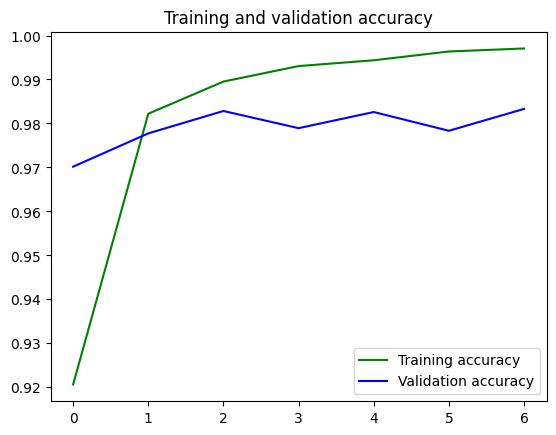

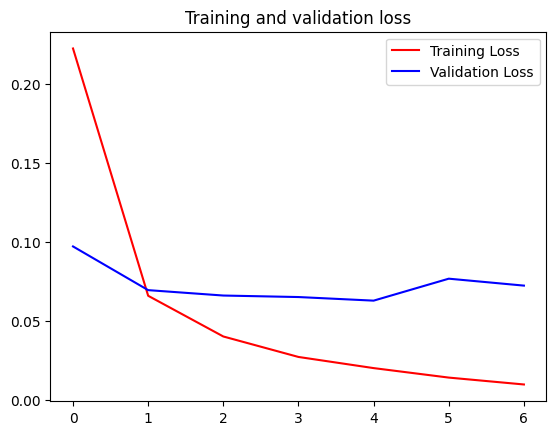

In [ ]:
plot_loss_acc(history)

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

In [ ]:
tflite_models_dir = pathlib.Path("/content/")
tflite_models_dir.mkdir(exist_ok=True, parents=True)
tflite_model_file = tflite_models_dir/"hoaxgy.tflite"
tflite_model_file.write_bytes(tflite_model)

2015544

In [ ]:
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()
tflite_model_quant_file = tflite_models_dir/"hoaxgy.tflite"
tflite_model_quant_file.write_bytes(tflite_quant_model)

506264

In [ ]:
interpreter = tf.lite.Interpreter(model_path=str(tflite_model_file))
interpreter.allocate_tensors()

In [ ]:
interpreter_quant = tf.lite.Interpreter(model_path=str(tflite_model_quant_file))
interpreter_quant.allocate_tensors()

In [ ]:
test_text = np.expand_dims(testing_padded[0], axis=0).astype(np.float32)

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

interpreter.set_tensor(input_index, test_text)
interpreter.invoke()
predictions = interpreter.get_tensor(output_index)

In [ ]:
# A helper function to evaluate the TF Lite model using "test" dataset.
def evaluate_model(interpreter):
  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]

  # Run predictions on every image in the "test" dataset.
  prediction_digits = []
  for test_text in testing_padded:
    # Pre-processing: add batch dimension and convert to float32 to match with
    # the model's input data format.
    test_text = np.expand_dims(test_text, axis=0).astype(np.float32)
    interpreter.set_tensor(input_index, test_text)

    # Run inference.
    interpreter.invoke()

    # Post-processing: remove batch dimension and find the digit with highest
    # probability.
    output = interpreter.tensor(output_index)
    digit = np.argmax(output()[0])
    prediction_digits.append(digit)

  # Compare prediction results with ground truth labels to calculate accuracy.
  accurate_count = 0
  for index in range(len(prediction_digits)):
    if prediction_digits[index] == testing_labels[index]:
      accurate_count += 1
  accuracy = accurate_count * 1.0 / len(prediction_digits)

  return accuracy

In [ ]:
print(evaluate_model(interpreter))

0.7684384988753403


In [ ]:
print(evaluate_model(interpreter_quant))

0.7684384988753403


In [ ]:
model.save("hoaxgy.h5")